# Bayesian classifier
<a id='start'></a>

This note book obtains bayesian classifier for suite image from training set.

Firstly, the raw images with ground truth are segmented using the methods in main notebooks to crop suite images out. This step is supervised so that no missegmentation occurs.

Secondly, the fourier descriptors of suite countours are extracted. We use fourier descriptors as features because suite images are very simple shapes with few variations. According to different card colors, different fourier coefficient are representative for suites. Spade and club are similar in outer boundaries but different in details. So we take higher order fourier coefficeints. Heart and Diamond are different in outer boundaries as diamond is very sharp. We take lower order fourier coefficeints.

Thirdly, we assume a Gaussian destribution of fourier descriptor features and calculate the decision curve between classes. We will be using these decision curves in the main notebook for classifying suite images in test sets.

## Import dependencies

In [30]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import csv
import sympy as sym
import math
import skimage
import skimage.morphology
import skimage.io

## Segmentation functions

The segmentation functions work the same as in main notebook to crop the suite image from raw photos. The performace of segmentation is checked to guarantee we get suite image for our training set.

In [31]:
def clean_img(im):
    gray_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    #blur the image for thresholding
    blur_im = cv2.GaussianBlur(gray_im,(3,3),0)
    #adaptive threshold OTSU
    ret, thresh_im = cv2.threshold(blur_im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #foreground is darker than background, so an inversion here
    thresh_im = 255 - thresh_im
    return thresh_im

In [32]:
rescale_factor = 0.25
disk1 = skimage.morphology.disk((int)(35*rescale_factor))
disk2 = skimage.morphology.disk((int)(13*rescale_factor))

In [33]:
def find_green_boxes(image,debug=False):
    """
    
    """
    # Preprocessing the image (grayscale + gaussian filter)
    #image = skimage.transform.rescale(image, rescale_factor, multichannel = True, anti_aliasing=False) 
    # hsv_fg = skimage.color.rgb2hsv(image)
    #hsv_fg = skimage.img_as_ubyte(hsv_fg)
    #green_mask = cv2.inRange(hsv_fg, (45,30,30), (115, 255,255))
    #blue_mask = cv2.inRange(hsv_fg, (115,125,125), (150, 255,255))
    #turn off gaussian filter 
    image = cv2.resize(image,None,fx=rescale_factor, fy=rescale_factor, interpolation = cv2.INTER_LINEAR)
    hsv_fg = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) 
    green_mask = cv2.inRange(hsv_fg, (25,35,35), (95, 255,255))
    blue_mask = cv2.inRange(hsv_fg, (80,110,110), (150, 255,255))
    

    
    ## slice the green
    binary = green_mask>0 
    binary_2 = blue_mask>0 
    binary = binary | binary_2
    
    dealer = skimage.morphology.opening(binary, disk1)
    dealer = skimage.morphology.closing(dealer, disk1)
    cards = binary ^ dealer
    cards = skimage.morphology.closing(cards, disk2)
    cards = skimage.img_as_ubyte(cards)
    
    if (debug):
        green = np.zeros_like(image)
        green[binary] = image[binary]
        return cards, dealer, green
    else:
        return cards, dealer

In [34]:
def crop_suite_value_MNIST(card_img):
    # Crop the suite
    suite_img = card_img[37:197, 20:135]

    # Crop the value
    value_img = card_img[171:541, 43:413]

    # Make it look like MNIST samples
    value_img = cv2.cvtColor(value_img, cv2.COLOR_BGR2GRAY)
    value_img = 255 - value_img
    _, value_img = cv2.threshold(value_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    value_img = cv2.GaussianBlur(value_img,(25,25),0)
    value_img = cv2.resize(value_img, (28, 28), interpolation = cv2.INTER_CUBIC)
    value_img = cv2.blur(value_img, (2,2), 0)

    return suite_img, value_img

In [35]:
def segmentation(cards_im, dealer_im, original_im):
    """
    
    """
    #get height and width of image
    height, width = original_im.shape[0], original_im.shape[1]

    # We use RETR_EXTERNAL mode to find external contour.
    contour = cv2.findContours(cards_im,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0] 
    
    # Keep the biggest contour only
    contour = sorted(contour, key=cv2.contourArea,reverse=True)
    contours_list = []
    for i in range(4):
        contours_list.append(contour[i][:, 0, :])
    
    contours_card = []
    M_card = []
    upper_left = []
    upper_right = []
    crop_imgs = []
    angles = []
    sizes = []
    for contour in contours_list:
        # Compute convex hull of contour
        hull = cv2.convexHull(contour)[:,0,:]
        hull = (1/rescale_factor * hull).astype(int)
        
        # Make sure contour is continuous
        if np.any(hull[0,:]!= hull[-1,:]):
            hull = np.vstack((hull,hull[0,:]))
            
        ##crop the tilted card as rectangle img
        # get min rect area enclosing contour
        rect = cv2.minAreaRect((1/rescale_factor * contour).astype(int)) 
        center, size, angle = rect[0], rect[1], rect[2]
        angles.append(angle)
        sizes.append(size)
        center, size = tuple(map(int, center)), tuple(map(int, size))
        # return tuple type: (center(x, y), (width, height), angle of rotation) = cv2.minAreaRect(points)
        box = cv2.boxPoints(rect)
        # keep box points for plotting function
        box = np.int0(box)
        # calculate the rotation matrix of card
        M = cv2.getRotationMatrix2D(center, angle, 1)
        # rotate the original image by the calculated matrix
        original_im_rot = cv2.warpAffine(original_im, M, (width, height))
        # crop the rotated rectangle is vertical to the card in for loop
        crop_img = cv2.getRectSubPix(original_im_rot, size, center)

        if crop_img.shape[0] < crop_img.shape[1]:
            crop_img_rescaled = cv2.resize(crop_img,(712, 466), interpolation = cv2.INTER_CUBIC)
        else:
            crop_img_rescaled = cv2.resize(crop_img,(466, 712), interpolation = cv2.INTER_CUBIC)
        crop_imgs.append(crop_img_rescaled)
        
        upper_left_corner = np.argmin(np.sum(box,axis=1))
        diag_vect_left = np.array([rect[0][0]-box[upper_left_corner,0], rect[0][1]-box[upper_left_corner,1]])
        
        if upper_left_corner == 3:
            upper_right_corner = 0
        else:
            upper_right_corner = upper_left_corner + 1
                
        diag_vect_right = np.array([rect[0][0]-box[upper_right_corner,0], rect[0][1]-box[upper_right_corner,1]])
        
        box = np.vstack((box,box[0,:]))
        center = rect[0]
        M_card.append(center)
        contours_card.append(box)
        upper_left.append(diag_vect_left)
        upper_right.append(diag_vect_right)

            
    # If contour is not a rectange (circle in our case)
    dealer_im = skimage.img_as_ubyte(dealer_im)
    # We use RETR_EXTERNAL mode to find external contour.
    contour_deal = cv2.findContours(dealer_im,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)[0] 
    
    # Keep the biggest contour only
    contour_deal = contour_deal[0][:,0,:]
    hull = cv2.convexHull(contour_deal)[:,0,:]
    hull = (1/rescale_factor*hull).astype(int)
    contour_dealer = hull
    M = cv2.moments(hull)
    cX = int(M["m10"] /M["m00"])
    cY = int(M["m01"] / M["m00"])
    M_dealer = np.array([cX,cY])
            
    # Assign moments to respective players   
    M_card_array = np.array(M_card)
    
    # sort player number
    player_one = np.argmax(M_card_array[:,1]) #max y in upper left corresponds to player 1 card upper left corner
    player_two = np.argmax(M_card_array[:,0]) #max x in upper right corresponds to player 2 card upper left corner
    player_three = np.argmin(M_card_array[:,1]) #min y in upper left corresponds to player 3 card upper left corner
    player_four = np.argmin(M_card_array[:,0]) #min x in upper right corresponds to player 4 card upper left corner

    # Segment player 1
    M_player_one = M_card_array[player_one,:]
    diag_one = upper_left[player_one]

    if sizes[player_one][0] < sizes[player_one][1]:
        crop_one = crop_imgs[player_one]
    elif sizes[player_one][0] >= sizes[player_one][1] and angles[player_one]<0:
        crop_one = cv2.rotate(crop_imgs[player_one], cv2.ROTATE_90_COUNTERCLOCKWISE)
    else:
        crop_one = cv2.rotate(crop_imgs[player_one], cv2.ROTATE_90_CLOCKWISE)

    suit_one,crop_value_one = crop_suite_value_MNIST(crop_one)

    # Segment player 2
    M_player_two = M_card_array[player_two,:]
    diag_two = upper_right[player_two]
    
    if sizes[player_two][0] > sizes[player_two][1]:
        crop_two = cv2.rotate(crop_imgs[player_two], cv2.ROTATE_90_CLOCKWISE)
    elif sizes[player_two][0] <= sizes[player_two][1] and angles[player_two]<0:
        crop_two = crop_imgs[player_two]
    else:
        crop_two = cv2.rotate(crop_imgs[player_two], cv2.ROTATE_180)

    suit_two,crop_value_two = crop_suite_value_MNIST(crop_two)

    # Segment player 3
    M_player_three = M_card_array[player_three,:]
    diag_three = upper_left[player_three]

    if sizes[player_three][0] < sizes[player_three][1]:
        crop_three = cv2.rotate(crop_imgs[player_three], cv2.ROTATE_180)
    elif sizes[player_three][0] >= sizes[player_three][1] and angles[player_three]<0:
        crop_three = cv2.rotate(crop_imgs[player_three], cv2.ROTATE_90_CLOCKWISE)
    else:
        crop_three = cv2.rotate(crop_imgs[player_three], cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    suit_three,crop_value_three = crop_suite_value_MNIST(crop_three)

    # Segment player 4
    M_player_four = M_card_array[player_four,:]
    diag_four = upper_right[player_four]

    if sizes[player_four][0] > sizes[player_four][1]:
        crop_four = cv2.rotate(crop_imgs[player_four], cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif sizes[player_four][0] <= sizes[player_four][1] and angles[player_four]<0:
        crop_four = cv2.rotate(crop_imgs[player_four], cv2.ROTATE_180)
    else:
        crop_four = crop_imgs[player_four]

    suit_four,crop_value_four = crop_suite_value_MNIST(crop_four)

    # Combine the result
    M_player = [M_player_one, M_player_two, M_player_three, M_player_four]
    diag_card = [diag_one, diag_two, diag_three, diag_four]
    suit_img = [suit_one,suit_two,suit_three,suit_four]
    value_img = [crop_value_one,crop_value_two,crop_value_three,crop_value_four]

    M_suit = []
        
    for diag, M in zip(diag_card, M_player):
        M_suit_y = M[0]- (int)(diag[0]*6.8/10)
        M_suit_x = M[1]- (int)(diag[1]*6.8/10)
        M_suit.append([M_suit_y, M_suit_x])

    # Find the dealer
    centroid_1 = np.array([1750, 3500])
    centroid_2 = np.array([2750, 2250])
    centroid_3 = np.array([1750, 750])
    centroid_4 = np.array([750, 2250])
    centroids = [centroid_1,centroid_2,centroid_3,centroid_4]
    dist = []
    for centroid in centroids:
        dist.append(np.sum(np.power((centroid-M_dealer),2)))

    dealer_assign = [0]*4
    dealer_assign[np.argmin(np.array(dist))] = 1

    return contour_dealer, contours_card, M_player, M_dealer, M_suit, suit_img, value_img, dealer_assign

## Suite feature extration

In this feature extraction function, we are extracting 2 fourier descriptors from cropped suite image.
The function completes two tasks.

Firstly, it applies a linear classifier to classify the average color of suite into red and black.
Secondly, depending on the result of color, it extracts 2 coefficients of fourier descriptors.

For better understanding of how this works please check session
[Understand the extracting of fourier descriptors](#section_test)

In [36]:
def get_fourier_descriptors(im):
    #preprocessing to remove blue&green contours
    hsv_fg = skimage.color.rgb2hsv(im)
    hsv_fg = skimage.img_as_ubyte(hsv_fg)
    #find green contours (union of green and blue mask)
    green_mask = cv2.inRange(hsv_fg, (45,30,30), (115, 255,255))
    blue_mask = cv2.inRange(hsv_fg, (115,125,125), (150, 255,255)) 
    bg_mask = cv2.bitwise_or(green_mask,blue_mask)
    open_mask = cv2.morphologyEx(bg_mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))
    open_mask_inv = cv2.bitwise_not(open_mask)
    #keep foreground with inverse of mask
    img_fg = cv2.bitwise_and(im,im,mask = open_mask_inv)
    img_empty = np.ones_like(img_fg)*255
    #set background to empty
    img_bg = cv2.bitwise_and(img_empty,img_empty,mask = open_mask)
    img_fgbg = cv2.add(img_fg,img_bg)
    #threshold image
    thresh_im = clean_img(img_fgbg)
    # We use RETR_EXTERNAL mode to find external contour, CHAIN_APPROX_NONE to keep all points without simplification.
    contour = cv2.findContours(thresh_im,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)[0] 
    # Keep the biggest contour only (the contour of suite shape)
    contour = sorted(contour, key=cv2.contourArea,reverse=True)
    contour_array = contour[0][:, 0, :]
    # color classification
    # create a mask of biggest contour
    color_mask = np.zeros_like(thresh_im)
    cv2.drawContours(color_mask, contour, 0, (255,255,255), -1)
    #calculate the average red channel value of shape
    red = cv2.mean(im, mask=color_mask)[2]
    # shape classification
    # Create an array storing the contour points in complex numbers
    contours_complex = np.empty(contour_array.shape[:-1], dtype=complex)
    contours_complex.real = contour_array[:, 0]
    contours_complex.imag = contour_array[:, 1]
    # Compute discrete Fourier Transform and get the amplitude
    fourier_result = np.fft.fft(contours_complex) 
    fourier_norm = np.absolute(fourier_result)
    # We abandon the 0's Fourier descriptor because it is variant to positions. 
    # We use first descriptor for normalizing all descriptors by the first one
    fourier_norm = fourier_norm/fourier_norm[1]
    isred = 0
    if (red > 100):
        isred = 1
        return fourier_norm[2], fourier_norm[3], isred
    else:
        return fourier_norm[6], fourier_norm[7], isred
    #2,3 for red set classification, diamond vs heart. Low frequency.
    #6,7 for black set classification, spade vs club. High frequency.

## Bayesian classifier

Functions for calculating decision plane given the train set with two classes.

In [37]:
def discriminant_function(x, mu, cov, prob_class):
    """
    Function that compute the discriminant function g(x) of one class
    """
    inv_cov = np.linalg.inv(cov)
    g = -1.0*np.matmul(np.matmul(x-mu,inv_cov),(x-mu)) +  np.log(prob_class) \
        + np.log(1.0/((2*math.pi)**(mu.shape[0]/2.0) * np.linalg.det(cov)**(1/2)))
    return g
def Bayes_Classification(all_data):
    """
    Function that computes the analytical expression of the separation curve for the bayes classification under assumption
    of normal distributions.
    
    Parameters
    ----------
    all_data : list of numpy.ndarray
        All the data as a list where each element correspond to a 2d-array of the data of one class.
    
    Returns
    -------
    decision_boundary : list of sympy.core.add.Add
        Symbolique expression for x1 and x2, that expresses the boundary between two classes
    g: list of sympy.core.add.Add
        Symbolique expression for x1 and x2, that expresses the discriminant function of one class
    """
    # Compute mean, covariance and number of data of each class
    mu, cov, prob_class = [], [], []
    nb_classes = len(all_data)
    for data in all_data:
        mean = np.mean(data, axis=0)
        mu.append(mean)
        cov.append(1/(data.shape[0]-1)*np.matmul((data-mean).transpose(),(data-mean)))
        prob_class.append(data.shape[0])
    
    # Convert the nb of data of each class into its probability by diving by the total amout of data
    prob_class = np.array(prob_class)
    prob_class = prob_class/np.sum(prob_class)
    
    # Compute discriminant function
    g =  []
    x1 = sym.Symbol('x1', real=True)
    x2 = sym.Symbol('x2', real = True)
    for i in range(nb_classes):
        g_i = discriminant_function([x1,x2], mu[i], cov[i], prob_class[i])
        g_i = sym.expand(g_i)
        g.append(g_i)
    
    # Compute the decision hyperplane
    decision_boundary = []
    for i in range(nb_classes-1):
        for j in range(i+1, nb_classes):
            decision_boundary.append(g[i]-g[j])
            
    return decision_boundary, g

## Read raw images from training set and ground truth

Load train game photos and crop suite images to create train dataset with ground truth for Bayesian classifier.

In [38]:
#read data from train set
game_img_raw = []
game_img_suit_raw = []
suit_ground_truth = [] 
for i in range(7):
    #read ground truth
    with open('./games/game'+str(i+1)+'/game'+str(i+1)+'.csv') as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            suit_ground_truth.append(row[1][1])
            suit_ground_truth.append(row[2][1])
            suit_ground_truth.append(row[3][1])
            suit_ground_truth.append(row[4][1])
            #read imgs
    for j in range(13):
        game_img_raw.append(cv2.imread('./games/game'+str(i+1)+'/'+str(j+1)+'.jpg'))

In [39]:
#crop value, suit images and return dealer
suit_img_training = []
for i in range(len(game_img_raw)):
    cards, dealer = find_green_boxes(game_img_raw[i])
    _, _, _, _, _, suit_img, _, _ = segmentation(cards, dealer,game_img_raw[i])
    suit_img_training.append(suit_img[0])
    suit_img_training.append(suit_img[1])
    suit_img_training.append(suit_img[2])
    suit_img_training.append(suit_img[3])

In [40]:
game_img_suit_fourier_1 = []
game_img_suit_fourier_2 = []
for im in suit_img_training:
    game_img_suit_fourier_1.append(get_fourier_descriptors(im)[0])
    game_img_suit_fourier_2.append(get_fourier_descriptors(im)[1])

In [41]:
spade_training_set = []
diamond_training_set = []
club_training_set = []
heart_training_set = []
for i in range(len(suit_img_training)):
    if (suit_ground_truth[i]=='S'):
        spade_training_set.append([game_img_suit_fourier_1[i],game_img_suit_fourier_2[i]])
    if (suit_ground_truth[i]=='D'):
        diamond_training_set.append([game_img_suit_fourier_1[i],game_img_suit_fourier_2[i]])
    if (suit_ground_truth[i]=='C'):
        club_training_set.append([game_img_suit_fourier_1[i],game_img_suit_fourier_2[i]])
    if (suit_ground_truth[i]=='H'):
        heart_training_set.append([game_img_suit_fourier_1[i],game_img_suit_fourier_2[i]])

## Understand the extracting of fourier descriptors
<a id='section_test'></a>

Load test image. This is suite image cropped from game 1, turn 1, player 3

In [44]:
im = cv2.imread('./data/training/suite_raw_example.jpg')

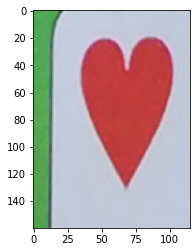

In [45]:
plt.imshow(im)

For better results, we do preprocessing to remove blue & green contours due to imperfect cropping

Use range in HSV space to find mask of unwanted green 

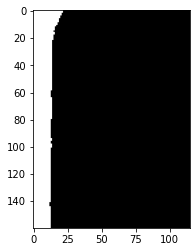

In [47]:
hsv_fg = skimage.color.rgb2hsv(im)
hsv_fg = skimage.img_as_ubyte(hsv_fg)
green_mask = cv2.inRange(hsv_fg, (45,30,30), (115, 255,255))
blue_mask = cv2.inRange(hsv_fg, (115,125,125), (150, 255,255)) 
bg_mask = cv2.bitwise_or(green_mask,blue_mask)
plt.imshow(bg_mask,cmap='gray')

Crop unwanted green off image

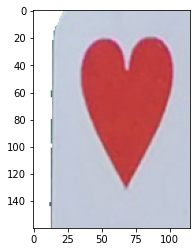

In [48]:
open_mask = cv2.morphologyEx(bg_mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))
open_mask_inv = cv2.bitwise_not(open_mask)
#keep foreground with inverse of mask
img_fg = cv2.bitwise_and(im,im,mask = open_mask_inv)
img_empty = np.ones_like(img_fg)*255
#set background to empty
img_bg = cv2.bitwise_and(img_empty,img_empty,mask = open_mask)
img_fgbg = cv2.add(img_fg,img_bg)
plt.imshow(img_fgbg)

Clean and threshold image

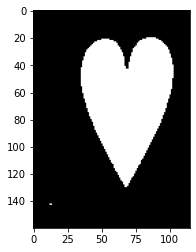

In [49]:
thresh_im = clean_img(img_fgbg)
plt.imshow(thresh_im,cmap = 'gray')

Find the biggest contour, which is the contour of suite shape. Use this contour area as a mask.

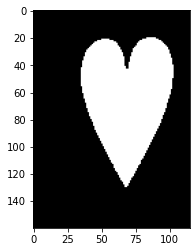

In [50]:
contour = cv2.findContours(thresh_im,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)[0] 
contour = sorted(contour, key=cv2.contourArea,reverse=True)
contour_array = contour[0][:, 0, :]
color_mask = np.zeros_like(thresh_im)
cv2.drawContours(color_mask, contour, 0, (255,255,255), -1)
plt.imshow(color_mask,cmap = 'gray')

In [51]:
red = cv2.mean(im, mask=color_mask)[2]
print(f'average red value of suite image is {255 - red:.2f}')

average red value of suite image is 187.79


We used cv2.CHAIN_APPROX_NONE in finding coontours. So we keep all contour points. Save contours as complex sigmal and do FFT and normalize. 

In [52]:
contours_complex = np.empty(contour_array.shape[:-1], dtype=complex)
contours_complex.real = contour_array[:, 0]
contours_complex.imag = contour_array[:, 1]
# Compute discrete Fourier Transform and get the amplitude
fourier_result = np.fft.fft(contours_complex) 
fourier_norm = np.absolute(fourier_result)
fourier_norm = fourier_norm/fourier_norm[1]

From train set with labels it can be seen that the classes can be well seperated.

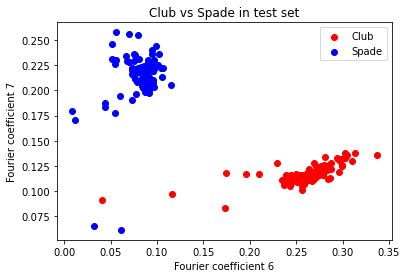

In [58]:
xs = [x[0] for x in spade_training_set]
ys = [x[1] for x in spade_training_set]
plt.scatter(xs,ys,c='r')
xs = [x[0] for x in club_training_set]
ys = [x[1] for x in club_training_set]
plt.scatter(xs,ys,c='b')
plt.xlabel('Fourier coefficient 6')
plt.ylabel('Fourier coefficient 7')
plt.title('Club vs Spade in test set')
plt.legend(['Club','Spade'])

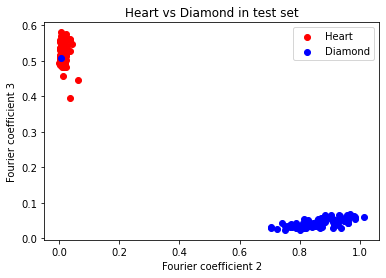

In [59]:
xs = [x[0] for x in diamond_training_set]
ys = [x[1] for x in diamond_training_set]
plt.scatter(xs,ys,c='r')
xs = [x[0] for x in heart_training_set]
ys = [x[1] for x in heart_training_set]
plt.scatter(xs,ys,c='b')
plt.xlabel('Fourier coefficient 2')
plt.ylabel('Fourier coefficient 3')
plt.title('Heart vs Diamond in test set')
plt.legend(['Heart','Diamond'])

## Final decision curve of Bayesian classifier 

We calculate and show decision plane as quadrics. The decision plane will then be used in main notebook.

In [22]:
# Putting our data in a list such that it is compatible with the function input
black_data = [np.asarray(spade_training_set),np.asarray(club_training_set)]
red_data = [np.asarray(diamond_training_set),np.asarray(heart_training_set)]
# We can now obtain the expression by calling the previous defined function
hyperplane1, g = Bayes_Classification(black_data)
hyperplane2, g = Bayes_Classification(red_data)
for _,hyp in enumerate(hyperplane1):
    print("Decision curve club-spade: \n", "g(x) =",hyp, "\n")
for _,hyp in enumerate(hyperplane2):
    print("Decision curve heart-diamond: \n", "g(x) =",hyp, "\n")

Decision curve club-spade: 
 g(x) = 2859.89042987933*x1**2 - 1233.09652151866*x1*x2 + 50.9525608771483*x1 - 3840.76833708728*x2**2 + 648.062279494321*x2 - 38.7202501408227 

Decision curve heart-diamond: 
 g(x) = -8631.68822729593*x1**2 + 334.043833410848*x1*x2 + 28.8862082239766*x1 - 401.333957105818*x2**2 + 743.09053520083*x2 - 182.895039049464 

